In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

# Random Forest model for OCM historical episodes

In this script is an example of how to train and evaluate the performance of a random forest model for predicitng episode prices using OCM CMMI historical claims data.

## Base Episodes

We can illustrate the procedure to train and evalute an RF model with these 17,500 base episodes:

* site1: 2,588
* site2: 2,325
* site3: 3,055
* site4: 516
* site5: 1,428
* site6: 2,144
* site7: 4,949

## OCM Prediction Model Covariates:

* Age/Sex
* Cancer type
* Chemotherapy drugs taken/administered during the episode (breast cancer only)
* Receipt of cancer-related surgery
* Part D eligibility and dual eligibility for Medicare and Medicaid
* Receipt of radiation therapy
* Receipt of bone marrow transplant
* Clinical trial participation
* Comorbidities
* History of prior chemotherapy use
* Insitutional status
* Episode length
* Geographic location/Hospital Referral Region (use lat/lng pairs derived from zipcode)

## Add Episode begin date, Episode end date, and DOB


In [2]:
# Change to the directory where the historical episode files are housed

preDouble = "\\\\iobsdc01\\SharedDocs\\Development\\Clients\\2012 - 2015"
new = os.chdir(preDouble)
#print(preDouble)

# read in the files

ucs = pd.read_table("OCM_143_50264_episodes_base_20160804.txt", sep="|")
oha = pd.read_table("OCM_414_50280_episodes_base_20160812.txt", sep="|")
hfci = pd.read_table("OCM_431_50233_episodes_base_20160902.txt", sep="|")
iha = pd.read_table("OCM_057_50173_episodes_base_20160722.txt", sep="\t")
nmcc = pd.read_table("OCM_108_50279_episodes_base_20160812.txt", sep="|")
dpn = pd.read_table("OCM_024_50116_episodes_base_20160916.txt", sep="|")
somc = pd.read_table("OCM_514_50286_episodes_base_20160715.txt", sep="|")
ucs["Practice"] = "UCS"
oha["Practice"] = "OHA"
hfci["Practice"] = "HFCI"
iha["Practice"] = "IHA"
nmcc["Practice"] = "NMCC"
dpn["Practice"] = "DPN"
somc["Practice"] = "SOMC"

# combine all the data into a single dataframe

df = pd.concat([ucs,oha,hfci,iha,nmcc,dpn,somc]).copy()

In [3]:
print(df.columns)

Index(['BENE_ID', 'BENE_HICN', 'FIRST_NAME', 'LAST_NAME', 'SEX', 'DOB', 'AGE',
       'DOD', 'ZIPCODE', 'EP_ID', 'EP_BEG', 'EP_END', 'EP_LENGTH',
       'CANCER_TYPE', 'RECON_ELIG', 'DUAL_PTD_LIS', 'INST', 'RADIATION',
       'HCC_GRP', 'HRR_REL_COST', 'SURGERY', 'CLINICAL_TRIAL', 'BMT',
       'CLEAN_PD', 'PTD_CHEMO', 'ACTUAL_EXP', 'BASELINE_PRICE',
       'EXPERIENCE_ADJ', 'Practice'],
      dtype='object')


# First turn the zipcodes into (lat/lng/elev) triples

In [4]:
from geopy.distance import vincenty
from geopy.distance import great_circle

df['goodzip'] = df.ZIPCODE.map("{:05}".format)

from geopy.geocoders import Nominatim
geolocator = Nominatim()
import geocoder
def make_zip_dicts(t):
    """takes the list t and returns a 3 
    dictionaries: d_zip_lat, d_zip_lng, and
    d_zip_elev."""
    d_zip_lat = {}
    d_zip_lng = {}
    d_zip_elev = {}
    for z in t:
        try:
            location = geolocator.geocode(z)
            g = geocoder.elevation((location.latitude,location.longitude))
            d_zip_lat[z] = location.latitude
            d_zip_lng[z] = location.longitude
            d_zip_elev[z] = g.elevation
        except:
            d_zip_lat[z] = np.nan
            d_zip_lng[z] = np.nan
            d_zip_elev[z] = np.nan
    return d_zip_lat, d_zip_lng, d_zip_elev

d_zip_lat, d_zip_lng, d_zip_elev = make_zip_dicts([x for x in df['goodzip'].value_counts().index])


df['latitude'] = df['goodzip'].replace(d_zip_lat).copy()
df['longitude'] = df['goodzip'].replace(d_zip_lng).copy()
df['elevation'] = df['goodzip'].replace(d_zip_elev).copy()

# Only keep those episides that are recon eligible

In [5]:
recon_filter = (df.RECON_ELIG == 1)
dg = df[recon_filter].copy()

# turn the episode begin and end dates into epoch times, as well as DOB

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
from scipy import stats

dg['EP_BEG_NEW'] = dg['EP_BEG'].astype('str').replace('\.0','').copy()
dg['EP_BEG_NEW'] = dg['EP_BEG_NEW'].str.rjust(8,'0')
dg['EP_BEG_NEW'] = pd.to_datetime(dg['EP_BEG_NEW'],
                                 format='%Y%m%d').copy()

dg['EP_END_NEW'] = dg['EP_END'].astype('str').replace('\.0','').copy()
dg['EP_END_NEW'] = dg['EP_END_NEW'].str.rjust(8,'0')
dg['EP_END_NEW'] = pd.to_datetime(dg['EP_END_NEW'],
                                 format='%Y%m%d').copy()

dg['EP_DELTA'] = dg['EP_END_NEW'] - dg['EP_BEG_NEW']

def make_days(i):
    return i.days

dg['EP_DELTA_DAYS'] = dg['EP_DELTA'].apply(make_days)

dg['DOB_NEW'] = dg['DOB'].astype('str').replace('\.0','').copy()
dg['DOB_NEW'] = dg['DOB_NEW'].str.rjust(8,'0')
dg['DOB_NEW'] = pd.to_datetime(dg['DOB_NEW'],
                                 format='%Y%m%d').copy()

dg['EP_BEG_NEW_EPOCH'] = dg['EP_BEG_NEW'].astype(np.int64) // 10**9

dg['EP_END_NEW_EPOCH'] = dg['EP_END_NEW'].astype(np.int64) // 10**9

dg['DOB_NEW_EPOCH'] = dg['DOB_NEW'].astype(np.int64) // 10**9

# Transform the categorical variables (one-hot-encode them) so that it be used as input

In [8]:
# results in a data frame (with no intercept column) where the all of the "C" variables below have been one-hot-encoded
formula_all_forest = """ACTUAL_EXP ~ -1 + EP_BEG_NEW_EPOCH + EP_END_NEW_EPOCH + 
DOB_NEW_EPOCH + latitude + longitude + C(SEX) + EP_DELTA_DAYS +
C(DUAL_PTD_LIS) + C(INST) + C(RADIATION) + C(HCC_GRP) + C(SURGERY) +
C(CLINICAL_TRIAL) + C(BMT) + C(CLEAN_PD) + C(PTD_CHEMO)"""



yforest, Xforest = patsy.dmatrices(formula_all_forest,dg,return_type='dataframe')

In [9]:
df_forest = Xforest.copy()
df_forest['ACTUAL_EXP'] = yforest.copy()
df_forest.head()

,C(SEX)[1],C(SEX)[2],C(DUAL_PTD_LIS)[T.1],C(DUAL_PTD_LIS)[T.2],C(DUAL_PTD_LIS)[T.3],C(INST)[T.1],C(RADIATION)[T.1],C(HCC_GRP)[T.00],C(HCC_GRP)[T.01],C(HCC_GRP)[T.02],...,C(CLEAN_PD)[T.3],C(PTD_CHEMO)[T.1],C(PTD_CHEMO)[T.2],EP_BEG_NEW_EPOCH,EP_END_NEW_EPOCH,DOB_NEW_EPOCH,latitude,longitude,EP_DELTA_DAYS,ACTUAL_EXP
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.326067e+09,1.341706e+09,-1.128470e+09,40.755604,-111.883172,181.0,461.78
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.366243e+09,1.381968e+09,-9.648288e+08,40.568508,-112.297001,182.0,54480.02
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.326240e+09,1.341878e+09,-1.104365e+09,40.805689,14.691350,181.0,25121.25
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.341965e+09,1.357776e+09,-1.104365e+09,40.805689,14.691350,183.0,18799.51
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.387757e+09,1.403395e+09,-1.234915e+09,42.557720,-70.824889,181.0,5283.13


# Break into training and test sets

In [10]:
from sklearn.model_selection import train_test_split
X = df_forest.iloc[:,:-1].values
y = df_forest['ACTUAL_EXP'].values

# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X,
        y, test_size=0.2, random_state=10)

# Scale data
from sklearn.preprocessing import StandardScaler, RobustScaler


robust_scaler = RobustScaler()
Xtr_r = robust_scaler.fit_transform(X_train)
Xte_r = robust_scaler.transform(X_test)

#ytr_r = y_train.copy()
#yte_r = y_test.copy()

#robust_scaler_y = StandardScaler()
#ytr_r = robust_scaler_y.fit_transform(y_train.reshape(-1,1))
#yte_r = robust_scaler_y.transform(y_test.reshape(-1,1))

#ytr_r = ytr_r.reshape((y_train.shape[0],))
#yte_r = yte_r.reshape((y_test.shape[0],))

ytr_r = y_train.copy()
yte_r = y_test.copy()

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

In [12]:
rfextra = ExtraTreesRegressor(n_estimators=1000,
                             max_depth=50,max_features=.8)
rfextra.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=50,
          max_features=0.8, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
y_train_pred_rfextra = rfextra.predict(X_train)
y_test_pred_rfextra = rfextra.predict(X_test)

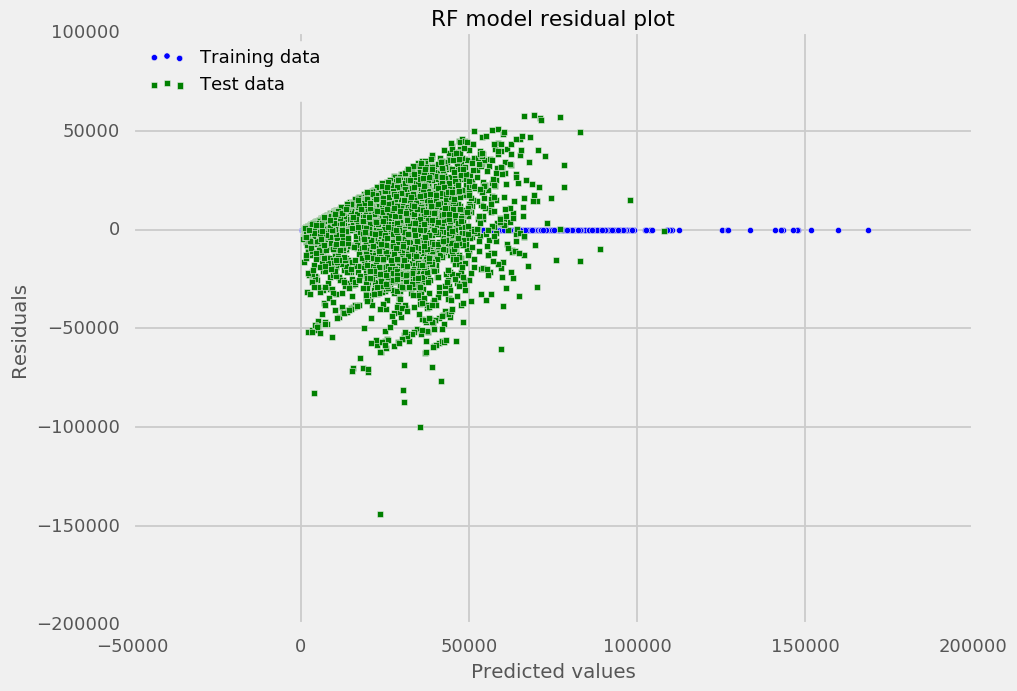

In [14]:
fig = plt.figure()
plt.scatter(y_train_pred_rfextra, y_train_pred_rfextra - y_train,
        c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_rfextra, y_test_pred_rfextra - y_test,
           c='green',marker='s',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.title('RF model residual plot')
plt.hlines(y=0, xmin=-5, xmax=4, lw=2, color='red')
#plt.xlim([-10,50])
plt.tight_layout()
plt.savefig('rfextra_residual',dpi=fig.dpi)

In [15]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f ' % (mean_squared_error(y_train, y_train_pred_rfextra),
                                         mean_squared_error(y_test, y_test_pred_rfextra)))

MSE train: 0.000, test: 362626717.503 


In [16]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_rfextra),
                                      r2_score(y_test,y_test_pred_rfextra)))

R^2 train: 1.000, test: 0.309


# <font color="#E56717">With the RF model, you can adjust the parameters of the forest (Fix the maximum depth each tree goes down) to prevent over-fitting, so that it has better predictive performance:</font>

# With the RF model, you can adjust the parameters of the forest (Fix the maximum depth each tree goes down) to prevent over-fitting, so that it has better predictive performance:

In [17]:
rfextra = ExtraTreesRegressor(n_estimators=1000,
                             max_depth=10,
                              min_samples_leaf=7,max_features=.5)
rfextra.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features=0.5, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=7, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
y_train_pred_rfextra = rfextra.predict(X_train)
y_test_pred_rfextra = rfextra.predict(X_test)

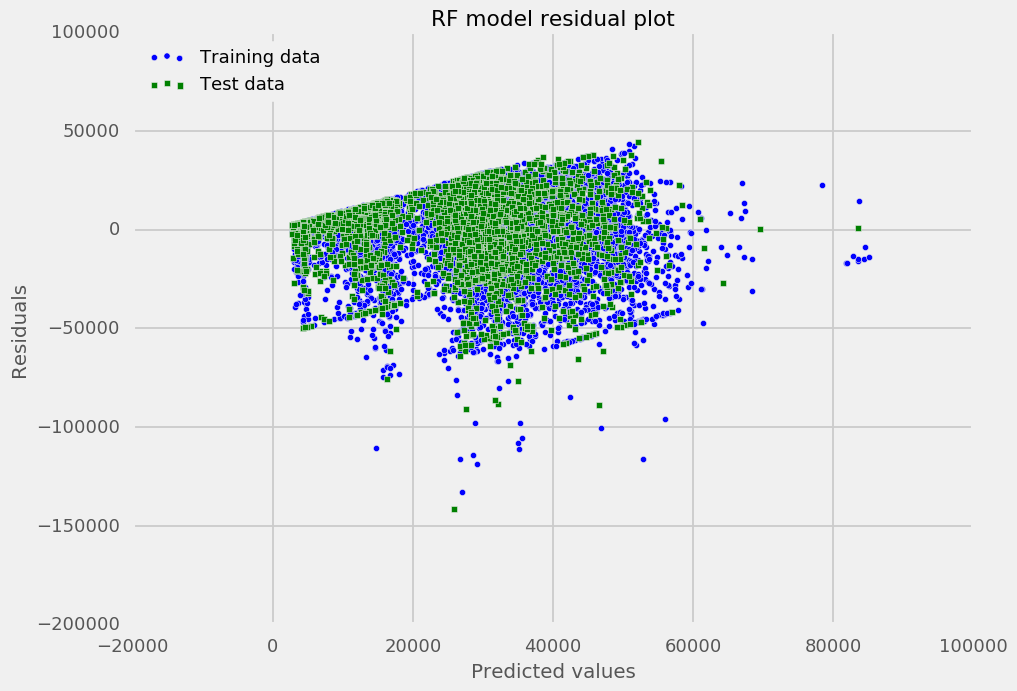

In [19]:

fig = plt.figure()
plt.scatter(y_train_pred_rfextra, y_train_pred_rfextra - y_train,
        c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_rfextra, y_test_pred_rfextra - y_test,
           c='green',marker='s',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.title('RF model residual plot')
plt.hlines(y=0, xmin=-5, xmax=4, lw=2, color='red')
#plt.xlim([-10,50])
plt.tight_layout()
plt.savefig('rfextra_residual',dpi=fig.dpi)

In [20]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f ' % (mean_squared_error(y_train, y_train_pred_rfextra),
                                         mean_squared_error(y_test, y_test_pred_rfextra)))

MSE train: 311351184.742, test: 326785652.723 


In [21]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_rfextra),
                                      r2_score(y_test,y_test_pred_rfextra)))

R^2 train: 0.405, test: 0.377


In [23]:
y_test.shape, y_train.shape

((3315,), (13256,))

# So training on just 13K episodes results in a model that achieves an R$^{2}$ of .377 on a set of unseen test data of size 3.3K

# With even more data, we will be able to allow for the RF model with greater comlplexity (the max_depth = 50 or some such number much greater than 10) and the resulting R$^{2}$ on the new test set will be substantially greater than .377 and both the test and train R$^{2}$ will see substantial increases over the .405 and .477 above that were achieved with the much smaller dataset.

# Below is a basic illustration using synthetic data showing how more data allows for greater model complexity and higher accuracy, which is what we expect to see when applying the above model framework to the 2.5 million historical claims files:

In [44]:
import numpy
import matplotlib.pyplot as plot
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO

#Build a simple data set with y = x + random

def make_synthetic(nPoints=100):
    xPlot = [(float(i)/float(nPoints) - 0.5) for i in range(nPoints + 1)]
    x = [[s] for s in xPlot]
    numpy.random.seed(1)
    y = [s + numpy.random.uniform(-.3,.3) for s in xPlot]
    #y = [s + (.1 - 0)*numpy.random.random_sample() for s in xPlot]
    #y = [s + numpy.random.random() for s in xPlot]

    nrow = len(x)

    depthList = [1,2,3,4,5,6,7,8,9,10]
    xvalMSE = []
    nxval = 10

    for iDepth in depthList:
    
    # build cross-validation loop to fit tree and evaluate on
    # out of sample data
        for ixval in range(nxval):
        
            # define test and training index sets
            idxTest = [a for a in range(nrow) if a%nxval == ixval%nxval]
            idxTrain = [a for a in range(nrow) if a%nxval != ixval%nxval]
        
            # define test and training attribute and lavel sets
            xTrain = [x[r] for r in idxTrain]
            xTest = [x[r] for r in idxTest]
            yTrain = [y[r] for r in idxTrain]
            yTest = [y[r] for r in idxTest]
        
            # train tree of appropriate depth and accumulate
            # out ot sample (oos) errors
            treeModel = DecisionTreeRegressor(max_depth=iDepth)
            treeModel.fit(xTrain, yTrain)
        
            treePrediction = treeModel.predict(xTest)
            error = [yTest[r] - treePrediction[r] for r in range(len(yTest))]
        
            # accumulate squared errors
            if ixval == 0:
                oosErrors = sum([e*e for e in error])
            else:
                # accumulate predictions
                oosErrors += sum([e*e for e in error])
            
        # average the squared errors and accomuluate by tree depth
    
        mse = oosErrors/nrow
        xvalMSE.append(mse)
    
    plot.plot(depthList, xvalMSE)
    plt.axis('tight')
    plt.xlabel('Tree Depth')
    plot.ylabel('Mean Squared Error')
    plt.title("Data Size :{0}".format(nPoints))

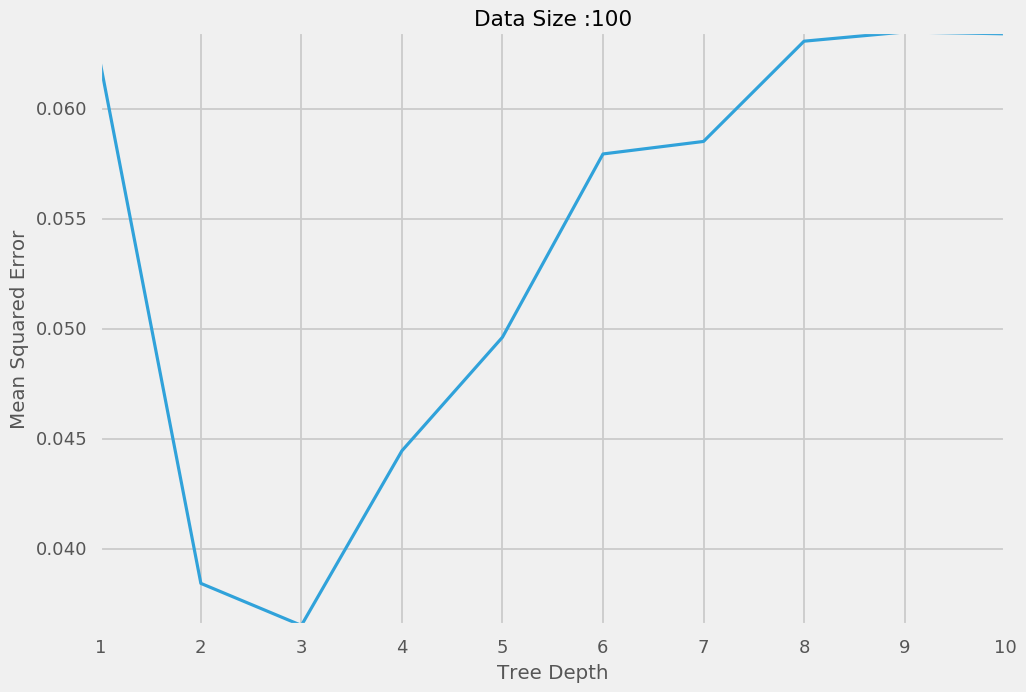

In [45]:
make_synthetic(100)

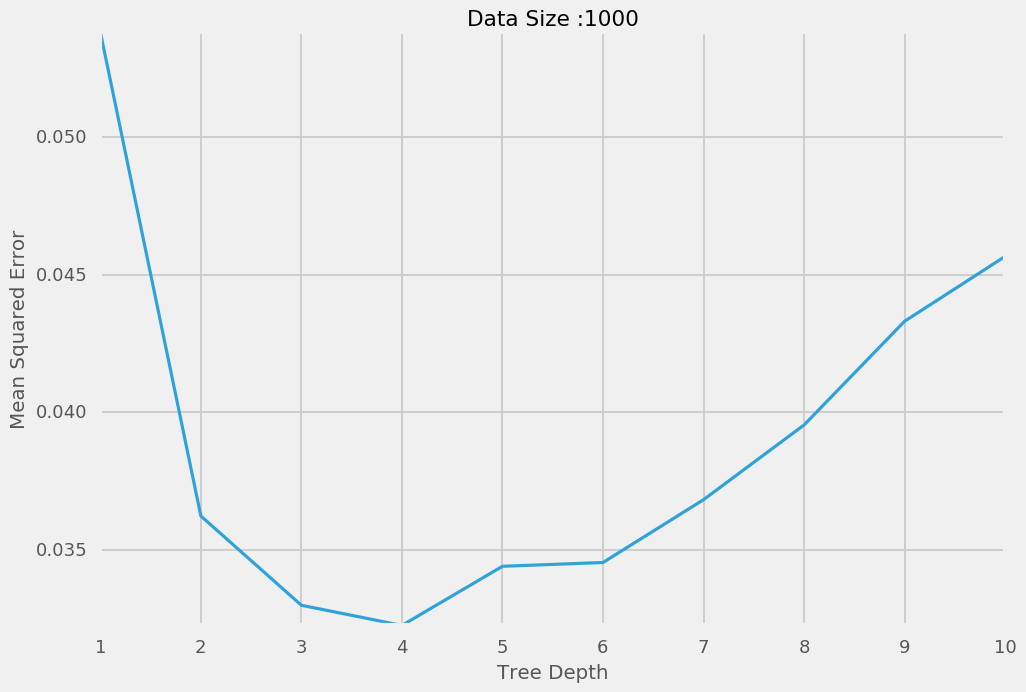

In [47]:
make_synthetic(1000)

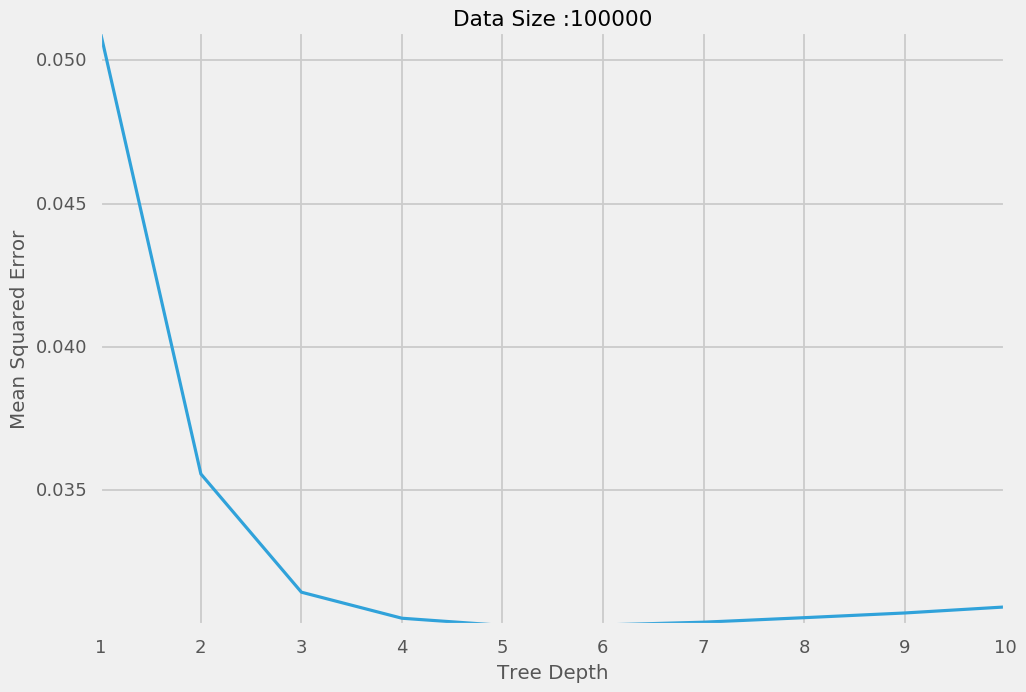

In [48]:
make_synthetic(100000)